# Téléchargment des vecteurs de mots pré-entraîné word2vec pour le corpus Google

In [2]:
import zipfile
import os

# Chemin vers le fichier ZIP téléchargé
zip_file_path = "googlenewsvectorsnegative300.zip"

# Répertoire où vous souhaitez extraire les fichiers
extract_to_directory = "./"
os.makedirs(extract_to_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

# Déclaration des constantes

In [1]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation 

label_to_numeric_3 = {'Positive': 1, 'Neutral': 0, 'Negative': -1}

tknzr = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
notstopwords = set(('not', 'no', 'never', 'nor'))
stop_words = set(stopwords.words('english')) - notstopwords

EMBEDDING_DIM = 300
EMBEDDING_FILE = "GoogleNews-vectors-negative300.bin"

Dim = 300
Unit = 64

label_to_numeric_7 = {
    '-3: very negative emotional state can be inferred': -3,
    '-2: moderately negative emotional state can be inferred': -2,
    '-1: slightly negative emotional state can be inferred': -1,
    '0: neutral or mixed emotional state can be inferred': 0,
    '1: slightly positive emotional state can be inferred': 1,
    '2: moderately positive emotional state can be inferred': 2,
    '3: very positive emotional state can be inferred': 3
}

# Déclaration des différentes fonctions nécessaires

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as stats_pearsonr

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPooling1D, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk import pos_tag

from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences

def read_data_source(file_path):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)
    df = df.drop(df.columns[[0, 1]], axis=1)
    df = df[df['label'] != 'irrelevant']
    df['label'] = df['label'].map(label_to_numeric_3)
    df = df[df['label'].isin([0, 1, -1])]
    return df

def text_cleaning(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)    
    tweet = re.sub(r'@[A-Za-zA-Z0-9]+', '', tweet)  
    tweet = re.sub(r'@[A-Za-z]+', '', tweet)       
    tweet = re.sub(r'@[-)]+', '', tweet)            
    tweet = re.sub(r'#', '', tweet)              
    tweet = re.sub(r'RT[\s]+', '', tweet)          
    tweet = re.sub(r" (http|https) ?:\/\/[a-zA-Z0-9\.-]+\. [a-zA-Z]{2,4}(/\S*)?", " ", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r" can\'t", "cannot", tweet)
    tweet = re.sub(r"n\'t", "not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'s", "", tweet)
    tweet = re.sub(r"\'n", "", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    tweet = re.sub(r"@\w+", r' ', tweet)
    tweet = re.sub(r"#\w+", r' ', tweet)
    tweet = re.sub(r" [0-9]+", ",", tweet)
    tweet = re.sub(r'&[a-z;]+', '', tweet)       
    tweet = re.sub(r"\\u2019", "'", tweet)
    tweet = re.sub(r"\\u002c", "'", tweet)
    tweet = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a', 'n', 'v'] else 
             lemmatizer.lemmatize(i) for i,j in pos_tag(tknzr.tokenize(tweet))]
    tweet = [i for i in tweet if (i not in stop_words) and (i not in punctuation)]
    tweet = ' '.join(tweet)
    return tweet

def split_data(data):
    return (data['tweet'], data['label'])

def tokenize_tweets(x_train):
    max_vocab = 20000000
    tokenizer = Tokenizer(num_words=max_vocab)
    tokenizer.fit_on_texts(x_train)
    return tokenizer

def get_vocab_size(tokenizer):
    wordidx = tokenizer.word_index
    return (wordidx, len(wordidx))

def sequence_tweets(tokenizer, x_train, x_test):
    return (tokenizer.texts_to_sequences(x_train),tokenizer.texts_to_sequences(x_test))

def align_sequences(train_seq, test_seq):
    return (pad_sequences(train_seq), pad_sequences(train_seq).shape[1], pad_sequences(test_seq, maxlen=pad_sequences(train_seq).shape[1]))

def create_embedding_matrix(V, wordidx):
    oov=[]
    oov.append((np.random.rand(EMBEDDING_DIM) * 2.0) - 1.0)
    oov = oov / np.linalg.norm(oov)
    embedding_matrix = np.zeros((V + 1, EMBEDDING_DIM))
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

    for word, i in wordidx.items():
        if word in word2vec.key_to_index:
            embedding_matrix[i] = word2vec.get_vector(word)
        else:
            embedding_matrix[i] = oov
    return embedding_matrix

def model_3(T, V, embedding_matrix):
    model = Sequential()
    model.add(Input(shape=(T,), name='input'))
    model.add(Embedding(V + 1, Dim, embeddings_initializer=Constant(embedding_matrix), trainable=True))
    model.add(Bidirectional(LSTM(Unit, return_sequences=True), name='bidirectional_lstm_1'))
    model.add(Dropout(0.5, name='dropout_1'))
    model.add(Bidirectional(LSTM(Unit, return_sequences=True), name='bidirectional_lstm_2'))
    model.add(GlobalMaxPooling1D(name='global_max_pooling'))
    model.add(Dense(32, activation='relu', name='dense_1'))
    model.add(Dense(3, activation='softmax', name='dense_2'))
    
    for i in range(len(model.weights)):
        model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)
            
    tf.keras.backend.clear_session()
    return model

def encode_y(y_train, y_test, n):
    return (to_categorical(y_train, num_classes=n), to_categorical(y_test, num_classes=n))

def train_model_3(model, pad_train, pad_test, y_train, y_test, epochs, nb_class):
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    y_train_one_hot, y_test_one_hot = encode_y(y_train, y_test, nb_class)

    return model.fit(pad_train, y_train_one_hot, validation_data=(pad_test, y_test_one_hot), epochs=epochs, callbacks=[early_stopping])

def training_accuracy(trained_model):
    plt.plot(trained_model.history['accuracy'], label= 'accuracy')
    plt.plot(trained_model.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    
def saving_model(model):
    model.save('model.h5')

def evaluate(y_pred, y_val_one_hot):
    y_pred_argmax = y_pred.argmax(axis=1)
    y_val_argmax = y_val_one_hot.argmax(axis=1)
    return stats_pearsonr(y_pred_argmax, y_val_argmax)

def read_data_cible(file_path):
    data = pd.read_csv('data_seven/data_train.csv', sep='\t')
    data.dropna(inplace=True)
    data['label'] = data['label'].map(label_to_numeric_7)
    return data

# Classification en 3 classes

## Import des données et pré-traitements

In [3]:
data = read_data_source('data_three/twitter_training.csv')

X, y = split_data(data)

X = X.apply(text_cleaning)

x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20)

tokenizer = tokenize_tweets(x_train)

wordidx, V = get_vocab_size(tokenizer)

train_seq, test_seq = sequence_tweets(tokenizer, x_train, x_test)

pad_train, T, pad_test = align_sequences(train_seq, test_seq)

## Mise en place et entrainement du modèle

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 166, 300)       │     7,697,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 166, 128)       │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 166, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 166, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,987,323 (30.47 MB)

 Trainable params: 7,987,323 (30.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 305s 196ms/step - accuracy: 0.6656 - loss: 0.7563 - val_accuracy: 0.8513 - val_loss: 0.3896
Epoch 2/3
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 325s 213ms/step - accuracy: 0.8971 - loss: 0.2671 - val_accuracy: 0.8918 - val_loss: 0.2809
Epoch 3/3
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 530s 347ms/step - accuracy: 0.9391 - loss: 0.1495 - val_accuracy: 0.9001 - val_loss: 0.2787


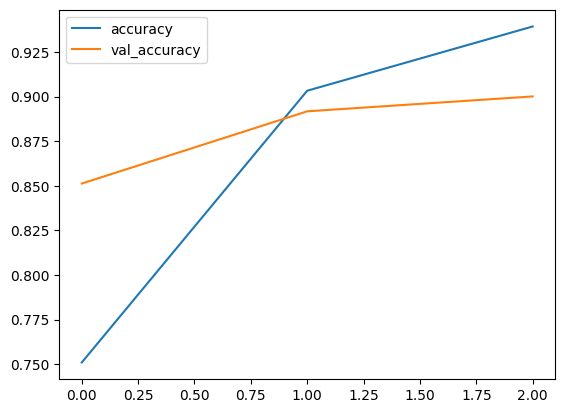

In [4]:
embedding_matrix = create_embedding_matrix(V, wordidx)

model = model_3(T, V, embedding_matrix)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

r = train_model_3(model, pad_train, pad_test, y_train, y_test, 3, 3)

training_accuracy(r)

## Sauvegarde des poids du modèle

In [5]:
model.save_weights('poids_modele.weights.h5')

## Validation du modèle

In [6]:
model1 = model_3(T, V, embedding_matrix)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.load_weights('poids_modele.weights.h5')

data_val = read_data_source('data_three/twitter_validation.csv')

X_val, y_val = split_data(data_val)

X_val = X_val.apply(text_cleaning)

y_val_one_hot = to_categorical(y_val, num_classes=3)

X_val_seq = tokenizer.texts_to_sequences(X_val)

X_val_pad = pad_sequences(X_val_seq, maxlen=T)

y_pred = model1.predict(X_val_pad)

pearsonr_value, _ = evaluate(y_pred, y_val_one_hot)
print("Corrélation de rang de Pearson :", pearsonr_value)

c:\python\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step
Corrélation de rang de Pearson : 0.9294724438735832


# Transfert Learning : Classification en 7 classes

## Import des données et pré-traitements

In [7]:
data_7 = read_data_cible('data_seven/data_train.csv')

X_7, y_7 = split_data(data_7)

X_7 = X_7.apply(text_cleaning)

x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(X_7.values, y_7.values, test_size=0.2)

tokenizer_7 = tokenize_tweets(x_train_7)

wordidx_7, V_7 = get_vocab_size(tokenizer_7)

train_seq_7, test_seq_7 = sequence_tweets(tokenizer_7, x_train_7, x_test_7)

pad_train_7, T_7, pad_test_7 = align_sequences(train_seq_7, test_seq_7)

## Mise en place et entrainement du modèle

In [9]:
model7 = model_3(T, V, embedding_matrix)
model7.load_weights('poids_modele.weights.h5')

model7.pop()
model7.add(Dense(7, activation='softmax', name='dense_3'))

from keras.optimizers import Adam

learning_rate =  0.0001
custom_optimizer = Adam(learning_rate=learning_rate)

model7.compile(optimizer=custom_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model7.summary()

r_7 = train_model_3(model7, pad_train_7, pad_test_7, y_train_7, y_test_7, 100, 7)

training_accuracy(r_7)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 166, 300)       │     7,697,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 166, 128)       │       186,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 166, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 166, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling              │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,987,455 (30.47 MB)

 Trainable params: 7,987,455 (30.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.1866 - loss: 2.4361 - val_accuracy: 0.1688 - val_loss: 2.2090
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.1848 - loss: 2.2042 - val_accuracy: 0.1857 - val_loss: 2.1172
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2063 - loss: 2.1177 - val_accuracy: 0.1899 - val_loss: 2.0534
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2452 - loss: 2.0020 - val_accuracy: 0.1941 - val_loss: 2.0129
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.2570 - loss: 1.8920 - val_accuracy: 0.2194 - val_loss: 1.9855
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2651 - loss: 1.8875 - val_accuracy: 0.2068 - val_loss: 1.9639
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2825 - loss: 1.8535 - val_accuracy: 0.1983 - val_loss: 1.9495
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2943 - loss: 1.8237 - val_accuracy: 

## Validation du modèle

In [10]:
data_val_7 = read_data_cible('data_three/twitter_validation.csv')

X_val_7, y_val_7 = split_data(data_val_7)

X_val_7 = X_val_7.apply(text_cleaning)

y_val_one_hot_7 = to_categorical(y_val_7, num_classes=7)

X_val_seq_7 = tokenizer_7.texts_to_sequences(X_val_7)

X_val_pad_7 = pad_sequences(X_val_seq_7, maxlen=T_7)

y_pred_7 = model7.predict(X_val_pad_7)

pearsonr_value_7, _ = evaluate(y_pred_7, y_val_one_hot_7)
print("Corrélation de rang de Pearson :", pearsonr_value_7)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Corrélation de rang de Pearson : 0.2581763389130224
